EXAMEN SISTEMAS_DISTRIBUIDOS
Integrantes:
--Morales Luna Cinthia Selene
--Zurita Barbosa Fernanda Izamar
--Ortíz Peréz Víctor

In [1]:
#Como primeros pasos se importaron las librerias indispensables
#para la ejecución de cada uno de los apartados solicitados.
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from time import time
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN

In [2]:
#En primer lugar se define un dataframe de resultados que contiene
#cada unos de los meses con los que se trabajarán y las columnas requeridas.
df_resultados = pd.DataFrame(
    index=[1,2,3,4,5,6,7,8,9,10,11,12],
    columns = ['mes','mean_distance','tiempo_mean_distance',
               'mean_time','tiempo_mean_time','viajes_largos',
               'numero_taxis_diferentes','medallion_mas_viajes_largos',
               'numero_viajes_max_medallion'])

In [3]:
# leer todos los archivos de datos
plantilla="trip_data_{}.csv"

# En segundo lugar se realiza una conversión de datos en columnas
# que se lograron identificar previamente para evitar errores
# posteriores, de igual forma se generan nuevas columnas renombradas
# de forma que no afecten ejecuciones siguientes, también 
# se identifican las que son necesarias para la creación del
# dataframe de resultados mencionado con anterioridad y se eliminan
# las no indispensables, además, se identifican si existen renglones
# con errores en los datos, por ejemplo si hay columnas con 
# campos vacíos, de manera puntual en la columna identificada
# con el nombre (passenger_count) que contiene el número de pasajeros
# por taxi se realizó una limpieza de los datos tomando en cuenta solo
# aquellos en donde el numero de pasajeros fuera menor a 4
# de acuerdo a la siguiente referencia https://www.anuevayork.com/los-taxis-en-nueva-york/,
# igualmente se eliminan datos de las columnas en pickup_longitude,
# pickup_latitude, dropoff_longitude, dropoff_latitude, que contienen
# las coordenandas de llevada y recogida donde solo se conservan las que
# se encuentren dentro del rango siguiente (-74.253842,-73.709271) y (40.495089,40.910281). 

for mes in range (1,13):
    archivo = plantilla.format(mes)
    df = dd.read_csv(archivo, dtype={' store_and_fwd_flag': 'object', 'trip_time_in_secs': 'int64', 'passenger_count':'int64', 'rate_code':'int64'})
    #print (archivo)
    new_columns=['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude']
    df = df.rename(columns=dict(zip(df.columns, new_columns)))
    del df['store_and_fwd_flag']
    del df['rate_code']
    del df['vendor_id']
    del df['hack_license']
    df=df[(~df["medallion"].isnull()) & (~df["passenger_count"].isnull()) & (df["passenger_count"] < 4) & (~df["pickup_datetime"].isnull()) & (~df["dropoff_datetime"].isnull()) & (df["pickup_longitude"] > -74.253842) & (df["pickup_longitude"] <  -73.709271) & (df["pickup_latitude"] > 40.495089) & (df["pickup_latitude"] < 40.910281)]
        
    #{Propuesta}
    # El flujo de trabajo que se propone en esta solución es el siguiente:
    # Una vez descargados y descomprimidos los 12 archivos, se procede a una
    # lectura de cada uno de ellos, calculando y guardando resultados de cada archivo.
    # Para posteriormente trabajar con los resultados de los 12 archivos y generar la
    # solución solicitada. Para esto se requerieron 3 archivos:
    #
    # 1. Dataframe de resultados
    #        * mean_distance
    #        * tiempo_mean_distance
    #        * mean_time
    #        * tiempo_mean_time
    #        * viajes_largos
    #        * numero_taxis_diferentes
    #        * medallion_mas_viajes_largos
    #        * medallion_mas_viajes
    #        * numero_viajes_max_medallion
    #
    # 2. Dataframe para horas_día (que nos servirá para las gráficas por número de pasajeros)
    #        * no_pasajeros
    #        * pickup_datetime
    #
    # 3. Dataframe para medallion_mas_viajes (que nos servirá para las gráficas geográficas)
    #        * mes
    #        * medallion_mas_viajes
    #        * pickup_longitude, 
    #        * pickup_latitude, 
    #        * dropoff_longitude, 
    #        * dropoff_latitude,
    #        * pickup_datetime
    #        * dropoff_datetime        
    
    # Cálculo del promedio de distancia y del tiempo que se tardó en hacerlo.
    inicio = time()
    mean_distance = df['trip_distance'].mean().compute()
    fin = time()
    tiempo_mean_distance = fin-inicio
    
    # Cálculo del promedio de tiempo y del tiempo que se tardó en hacerlo.
    inicio = time()
    mean_time = df['trip_time_in_secs'].mean().compute()
    fin = time()
    tiempo_mean_time = fin-inicio
    
    # Cálculo de la duración de viaje, diferencia con la proporcionada y cuales son viajes largos
    df['dropoff_datetime']=dd.to_datetime (df['dropoff_datetime'])
    df['pickup_datetime']=dd.to_datetime (df['pickup_datetime'])
    df['duracion']=(df['dropoff_datetime']-df['pickup_datetime']).dt.seconds
    df['diferencia_tiempo']=df['duracion']-df['trip_time_in_secs']
    df['viaje_largo'] = (df['trip_time_in_secs']>(60*20))
    df.compute()
    
    
    # La ejecución de código siguiente cuenta el numero de viajes largos en cada archivo.    
    df_vl=df[df.viaje_largo==True]
    del df_vl['trip_time_in_secs']
    del df_vl['trip_distance']
    df_vl.compute()
    viajes_largos=len(df_vl)
    
    # De la columna generada identificada con el nombre viajes_largos se identifica
    # el número de taxis diferentes (la columna medallion contiene un numero que
    # identifica cada uno de los vehiculos). De lo anterior se obtiene ¿qué vehículos son los
    # que mas viajes realizan en cada mes? y si son el mismo vehículo.
    taxis_diferentes = df_vl.medallion.value_counts().compute()    
    numero_taxis_diferentes=len(taxis_diferentes)    
    medallion_mas_viajes_largos=taxis_diferentes.index[0]    
    numero_viajes_max_medallion = taxis_diferentes.max()        
    df_resultados.loc[mes] = [mes,mean_distance,tiempo_mean_distance,
                              mean_time,tiempo_mean_time,viajes_largos,
                              numero_taxis_diferentes,medallion_mas_viajes_largos,
                              numero_viajes_max_medallion]
    
    # Para el dataframe horas_día y medallion_mas_viajes
    # Si es el primer mes se crean los dataframes, sino se 
    # agregan al creado para Enero.
    if (mes == 1):
        # Creación de df_medallion_mas_viajes
        df_medallion_mas_viajes=df_vl[(df_vl['medallion']==medallion_mas_viajes_largos)]
        del df_medallion_mas_viajes['passenger_count']        
        del df_medallion_mas_viajes['duracion']        
        del df_medallion_mas_viajes['diferencia_tiempo']        
        del df_medallion_mas_viajes['viaje_largo']        
        df_medallion_mas_viajes=df_medallion_mas_viajes.compute()
        
        # Creación de df_horas_dia
        df_horas_dia=df_vl        
        del df_horas_dia['medallion']
        del df_horas_dia['dropoff_datetime']
        del df_horas_dia['pickup_longitude']
        del df_horas_dia['pickup_latitude']
        del df_horas_dia['dropoff_longitude']
        del df_horas_dia['dropoff_latitude']
        del df_horas_dia['duracion']
        del df_horas_dia['diferencia_tiempo']
        del df_horas_dia['viaje_largo']
        df_horas_dia=df_horas_dia.compute()        
    else:
        # Se agregan resultados del mes al df_medallion_mas_viajes
        medallion_mv=df_vl[(df_vl['medallion']==medallion_mas_viajes_largos)]
        del medallion_mv['passenger_count']                
        del medallion_mv['duracion']
        del medallion_mv['diferencia_tiempo']
        del medallion_mv['viaje_largo']
        medallion_mv=medallion_mv.compute()        
        df_medallion_mas_viajes=pd.concat([df_medallion_mas_viajes,medallion_mv])        
        
        # Se agregan resultados del mes al df_horas_dia
        df_hd=df_vl        
        del df_hd['medallion']
        del df_hd['dropoff_datetime']
        del df_hd['pickup_longitude']
        del df_hd['pickup_latitude']
        del df_hd['dropoff_longitude']
        del df_hd['dropoff_latitude']
        del df_hd['duracion']
        del df_hd['diferencia_tiempo']
        del df_hd['viaje_largo']        
        df_hd=df_hd.compute()
        df_horas_dia=pd.concat([df_horas_dia,df_hd])                                   
df_resultados
# La respuesta fue obtenida ejecutando el codigo siguiente:

c:\users\cinth\appdata\local\programs\python\python37\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
c:\users\cinth\appdata\local\programs\python\python37\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
c:\users\cinth\appdata\local\programs\python\python37\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
c:\users\cinth\appdata\local\programs\python\python37\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
c:\users\cinth\appdata\local\programs\py

,mes,mean_distance,tiempo_mean_distance,mean_time,tiempo_mean_time,viajes_largos,numero_taxis_diferentes,medallion_mas_viajes_largos,numero_viajes_max_medallion
1,1,2.76352,37.0769,683.093,35.3143,1488329,13101,DAF57CF25F00457CC6077CD628EC71AC,266
2,2,2.7364,35.0986,701.803,33.6521,1535544,13061,4E834DFB7A8831D0A5B6F9B80092A61F,259
3,3,2.83469,39.7607,716.837,37.4804,1825831,13127,4E834DFB7A8831D0A5B6F9B80092A61F,287
4,4,2.85436,39.8117,745.523,37.1301,1957664,13136,291470C747FCEEEB97C6A2CBB46A46AF,292
5,5,2.89776,38.6196,777.929,36.0791,2133638,13167,4E834DFB7A8831D0A5B6F9B80092A61F,320
6,6,2.93163,37.1505,780.032,34.2676,2069896,13214,698A6074D905BC18FE001032FA0B2048,312
7,7,2.89391,36.0879,748.331,33.2199,1797976,13134,5466D714601371299033C01FB08BB93B,306
8,8,87.4652,33.2604,1621.41,31.0123,1674104,13123,6BD1B641A1CD55803A21560299B985A7,307
9,9,2.97587,37.5562,784.327,34.6105,2111871,13170,8C3DB699DA9D5A86780602001DF0892D,318
10,10,2.94003,38.1381,783.448,36.1633,2226444,13170,8C3DB699DA9D5A86780602001DF0892D,319


In [4]:
# En la siguiente ejecución se indica el tiempo que tarda en obtener
# el promedio de la distancia de viaje (trip_distance) de 
# al dataframe creado de resultados df_resultados

# Cálculo del promedio de distancia y tiempo que se tardó en hacerlo para los 12 archivos.
inicio = time()
mean_distance_total = df_resultados['mean_distance'].mean()
fin = time()
tiempo_mean_distance_total = fin-inicio + df_resultados['tiempo_mean_distance'].sum()

# En la sguiente ejecución se indica el tiempo que tarda en obtener
# el promedio de la distancia de viaje (trip_distance) de 
# al dataframe creado de resultados df_resultados

# Cálculo del promedio de tiempo y tiempo que se tardó en hacerlo para los 12 archivos.
inicio = time()
mean_time_total = df_resultados['mean_time'].mean()
fin = time()
tiempo_mean_time_total = fin-inicio + df_resultados['tiempo_mean_time'].sum()

# En la siguiente ejecución se indica el número de viajes
# largos de al dataframe creado de resultados df_resultados 
viajes_largos_total = df_resultados['viajes_largos'].sum()

print ("El tiempo en sergundos que se tardó en calcular el promedio de la distancia para los 12 archivos es: ",tiempo_mean_distance_total)
print ("El tiempo en sergundos que se tardó en calcular el promedio de tiempo para los 12 archivos es: ",tiempo_mean_time_total)
print ("En el año se realizaron ", viajes_largos_total, " viajes mayores a 20 minutos.")

El tiempo en sergundos que se tardó en calcular el promedio de la distancia para los 12 archivos es:  447.0862708091736
El tiempo en sergundos que se tardó en calcular el promedio de tiempo para los 12 archivos es:  417.1323399543762
En el año se realizaron  22984497  viajes mayores a 20 minutos.


Text(0, 0.5, 'Número_de_pasajeros')

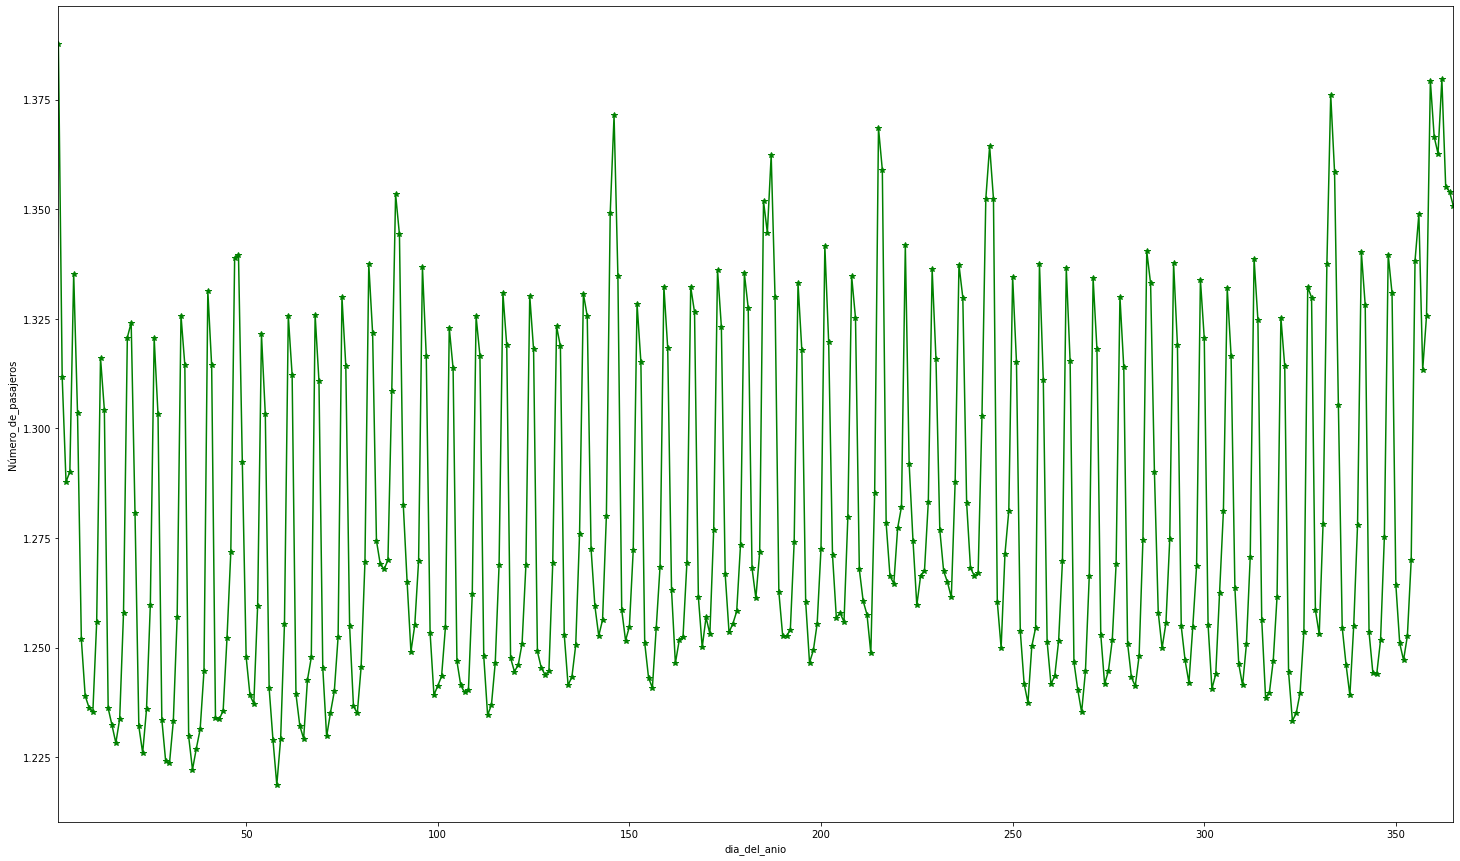

In [5]:
# La siguiente ejecución genera una gráfica temporal del número total de pasajeros, agregados por dias del año.

df_horas_dia["dia_del_anio"]= df_horas_dia["pickup_datetime"].dt.dayofyear
dia_anio = df_horas_dia.groupby('dia_del_anio')
resultado_pasajeros_dia = dia_anio.passenger_count.mean()
resultado_pasajeros_dia = resultado_pasajeros_dia
resultado_pasajeros_dia = resultado_pasajeros_dia.sort_index()
resultado_pasajeros_dia.plot.line(style="-*", figsize=(25,15), color="green")
plt.ylabel("Número_de_pasajeros")

Se puede notar que de acuerdo a la gráfica anual obtenida anteriormente se puede notar que los picos en los que existen un número mayor de pasajeros corresponden a los días festivos de los Estados Unidos:

--Existe un incremento de pasajeros a principios del mes de julio, debido al día de la independencia.
--Existe un incremento de pasajeros en el periodo del 15 de diciembre al 1 de enero, posiblemente debido a las fiestas decembrinas. 

Text(0, 0.5, 'Número de pasajeros')

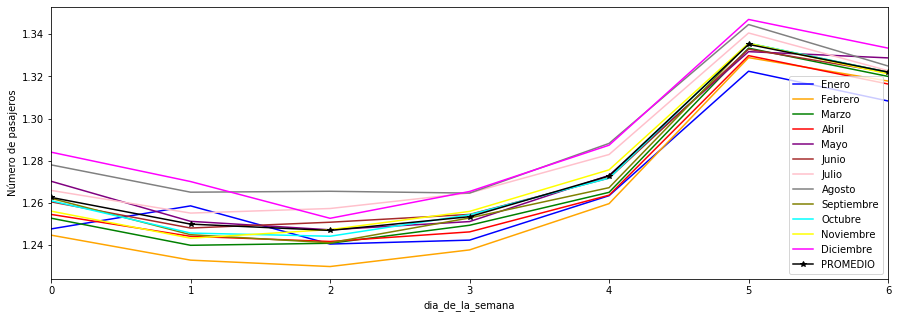

In [25]:
#La siguiente ejecución genera una gráfica temporal del número total de pasajeros, agregados por dias de la semana.

df_horas_dia["dia_de_la_semana"] = df_horas_dia["pickup_datetime"].dt.dayofweek
df_horas_dia["mes"] = df_horas_dia["pickup_datetime"].dt.month
colores = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow','magenta']
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre','Octubre', 'Noviembre', 'Diciembre','PROMEDIO']

for mes in range (1,13):
    df_horas_dia_mes = df_horas_dia[(df_horas_dia['mes']==mes)]
    dias_semana = df_horas_dia_mes.groupby("dia_de_la_semana")
    resultado_pasajeros_semana = dias_semana.passenger_count.mean()
    resultado_pasajeros_semana = resultado_pasajeros_semana.sort_index()
    resultado_pasajeros_semana.plot.line(style = "-", figsize=(15,5), color= colores[mes-1])
    plt.legend(meses)

dias_semana = df_horas_dia.groupby("dia_de_la_semana")
resultado_pasajeros_semana = dias_semana.passenger_count.mean()
resultado_pasajeros_semana = resultado_pasajeros_semana.sort_index()
resultado_pasajeros_semana.plot.line(style = "-*", figsize=(15,5), color= 'black')
plt.legend(meses)
plt.ylabel("Número de pasajeros")


La gráfica por día de la semana muestra que:

--El día con mayor cantidad de pasajeros es el sabado, seguido del domingo.
--El día con menor numero de pasajeros es el miercoles.

Text(0, 0.5, 'Número de pasajeros')

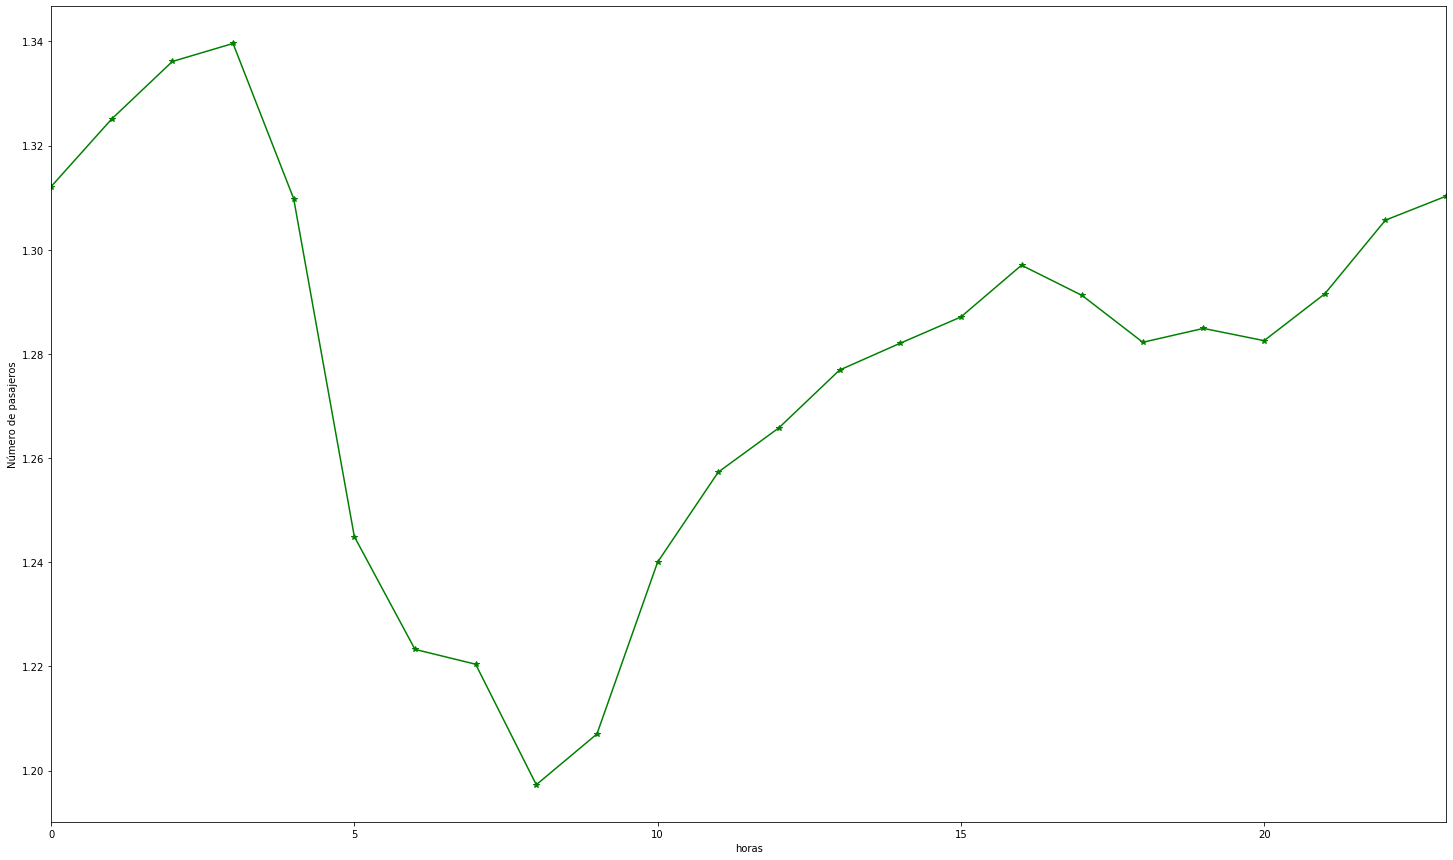

In [26]:
#La siguiente ejecución genera una gráfica temporal del número total de pasajeros, agregados por horas del día.

df_horas_dia["horas"] = df_horas_dia["pickup_datetime"].dt.hour
dias_horas = df_horas_dia.groupby("horas")
resultado_personas_horas = dias_horas.passenger_count.mean()
resultado_personas_horas = resultado_personas_horas
resultado_personas_horas = resultado_personas_horas.sort_index()
resultado_personas_horas.plot.line(style="-*", figsize=(25,15), color="green")
plt.ylabel("Número de pasajeros")

La gráfica por horas del dia muestra que:

--Los pasajeros aumentan a partir de las 6 de la noche -Los pasajeros disminuyen cerca de las 3 de la mañana 
--El pico mas bajo es cerca de las 6 de la mañana

In [8]:
df_medallion_mas_viajes=df_medallion_mas_viajes
resultado_medallion= pd.DataFrame()

def convertCoords(row):
    x2,y2 = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'),row['pickup_longitude'],row['pickup_latitude'])
    return pd.Series([x2,y2])

#Empiezan los mapas:
#En las siguientes lineas de ejecución se elige el vehiculo con mas viajes en cada mes y se grafica en un mapa los sitios 
#donde se bajan los pasajeros agrupados por dia de la semana (se distingue con un color distinto para cada dia de la semana)

NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='orange', size=5)
df_medallion_mas_viajes=df_medallion_mas_viajes
resultado_medallion= pd.DataFrame()
#Se realiza la conversion de las coordenadas geográficas de las columnas pickup_day y pickup_datetime que se encuentran en
#grados decimales al formato Web Mercator para la visualización de los resultados gráficos en mapas.
def convertCoords(row):
    x2,y2 = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'),row['pickup_longitude'],row['pickup_latitude'])
    return pd.Series([x2,y2])
df_medallion_mas_viajes[['columna_x','columna_y']]= df_medallion_mas_viajes.apply(convertCoords,axis=1)
df_medallion_mas_viajes['pickup_day']= df_medallion_mas_viajes['pickup_datetime'].dt.weekday
df_pu = df_medallion_mas_viajes[['columna_x','columna_y','pickup_day']].copy()
#Se crean dataframe para los arribos y llegadas de cada dia de la semana
df_pu_0 = df_pu[df_pu.pickup_day == 0]
df_pu_1 = df_pu[df_pu.pickup_day == 1]
df_pu_2 = df_pu[df_pu.pickup_day == 2]
df_pu_3 = df_pu[df_pu.pickup_day == 3]
df_pu_4 = df_pu[df_pu.pickup_day == 4]
df_pu_5 = df_pu[df_pu.pickup_day == 5]
df_pu_6 = df_pu[df_pu.pickup_day == 6]

options1 = dict(line_color=None, fill_color='blue', size=7)
options2 = dict(line_color=None, fill_color='red', size=7)
options3 = dict(line_color=None, fill_color='yellow', size=7)
options4 = dict(line_color=None, fill_color='green', size=7)
options5 = dict(line_color=None, fill_color='purple', size=7)
options6 = dict(line_color=None, fill_color='orange', size=7)
options7 = dict(line_color=None, fill_color='pink', size=7)

output_notebook()
muestras1 = df_pu_0.sample(n=200, replace=True)
muestras2 = df_pu_1.sample(n=200, replace=True)
muestras3 = df_pu_2.sample(n=200, replace=True)
muestras4 = df_pu_3.sample(n=200, replace=True)
muestras5 = df_pu_4.sample(n=200, replace=True)
muestras6 = df_pu_5.sample(n=200, replace=True)
muestras7 = df_pu_6.sample(n=200, replace=True)

p=base_plot()
p.add_tile(STAMEN_TERRAIN)

p.circle(x=muestras1['columna_x'], y = muestras1['columna_y'], **options1, legend='Lunes')
p.circle(x=muestras2['columna_x'], y = muestras2['columna_y'], **options2, legend='Martes')
p.circle(x=muestras3['columna_x'], y = muestras3['columna_y'], **options3, legend='Miercoles')
p.circle(x=muestras4['columna_x'], y = muestras4['columna_y'], **options4, legend='Jueves')
p.circle(x=muestras5['columna_x'], y = muestras5['columna_y'], **options5, legend='Viernes')
p.circle(x=muestras6['columna_x'], y = muestras6['columna_y'], **options6, legend='Sabado')
p.circle(x=muestras7['columna_x'], y = muestras7['columna_y'], **options7, legend='Domingo')

show(p)

Loading BokehJS ...

In [9]:
#En las siguientes lineas de ejecución se elige el vehiculo con mas viajes en cada mes y se grafica en un mapa los sitios 
#donde se bajan los pasajeros agrupados por dia de la semana (se distingue con un color distinto para cada dia de la semana)

#Se realiza la conversion de las coordenadas geográficas de las columnas dropoff_day y dropoff_datetime que se encuentran en
#grados decimales al formato Web Mercator para la visualización de los resultados gráficos en mapas.
def convertCoords(row):
    x2,y2 = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'),row['dropoff_longitude'],row['dropoff_latitude'])
    return pd.Series([x2,y2])
df_medallion_mas_viajes[['columnado_x','columnado_y']]= df_medallion_mas_viajes.apply(convertCoords,axis=1)
df_medallion_mas_viajes['dropoff_day'] = df_medallion_mas_viajes['dropoff_datetime'].dt.weekday
df_do = df_medallion_mas_viajes[['columnado_x','columnado_y','dropoff_day']].copy()
df_do_0 = df_do[df_do.dropoff_day == 0]
df_do_1 = df_do[df_do.dropoff_day == 1]
df_do_2 = df_do[df_do.dropoff_day == 2]
df_do_3 = df_do[df_do.dropoff_day == 3]
df_do_4 = df_do[df_do.dropoff_day == 4]
df_do_5 = df_do[df_do.dropoff_day == 5]
df_do_6 = df_do[df_do.dropoff_day == 6]
options1 = dict(line_color=None, fill_color='blue', size=7)
options2 = dict(line_color=None, fill_color='red', size=7)
options3 = dict(line_color=None, fill_color='yellow', size=7)
options4 = dict(line_color=None, fill_color='green', size=7)
options5 = dict(line_color=None, fill_color='purple', size=7)
options6 = dict(line_color=None, fill_color='orange', size=7)
options7 = dict(line_color=None, fill_color='pink', size=7)

output_notebook()
muestras8 = df_do_0.sample(n=200, replace=True)
muestras9 = df_do_1.sample(n=200, replace=True)
muestras10 = df_do_2.sample(n=200, replace=True)
muestras11 = df_do_3.sample(n=200, replace=True)
muestras12 = df_do_4.sample(n=200, replace=True)
muestras13 = df_do_5.sample(n=200, replace=True)
muestras14 = df_do_6.sample(n=200, replace=True)

p=base_plot()
p.add_tile(STAMEN_TERRAIN)

p.circle(x=muestras8['columnado_x'], y = muestras8['columnado_y'], **options1, legend='Lunes')
p.circle(x=muestras9['columnado_x'], y = muestras9['columnado_y'], **options2, legend='Martes')
p.circle(x=muestras10['columnado_x'], y = muestras10['columnado_y'], **options3, legend='Miercoles')
p.circle(x=muestras11['columnado_x'], y = muestras11['columnado_y'], **options4, legend='Jueves')
p.circle(x=muestras12['columnado_x'], y = muestras12['columnado_y'], **options5, legend='Viernes')
p.circle(x=muestras13['columnado_x'], y = muestras13['columnado_y'], **options6, legend='Sabado')
p.circle(x=muestras14['columnado_x'], y = muestras14['columnado_y'], **options7, legend='Domingo')
show(p)

Loading BokehJS ...

In [10]:
#En las siguientes lineas de ejecución se elige el vehiculo con mas viajes en cada mes y se grafica en un mapa los sitios 
#donde se suben los pasajeros agrupados por hora del dia ( se identifica con un color distinto para cada intervalo de 
#cuatro horas, 00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)

df_medallion_mas_viajes['segmento']=((df_medallion_mas_viajes['pickup_datetime'].dt.hour)//4)

df_dh_0 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 0]
df_dh_1 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 1]
df_dh_2 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 2]
df_dh_3 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 3]
df_dh_4 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 4]
df_dh_5 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 5]

options1 = dict(line_color=None, fill_color='blue', size=7)
options2 = dict(line_color=None, fill_color='red', size=7)
options3 = dict(line_color=None, fill_color='yellow', size=7)
options4 = dict(line_color=None, fill_color='green', size=7)
options5 = dict(line_color=None, fill_color='purple', size=7)
options6 = dict(line_color=None, fill_color='orange', size=7)

output_notebook()
muestras1 = df_dh_0.sample(n=200, replace=True)
muestras2 = df_dh_1.sample(n=200, replace=True)
muestras3 = df_dh_2.sample(n=200, replace=True)
muestras4 = df_dh_3.sample(n=200, replace=True)
muestras5 = df_dh_4.sample(n=200, replace=True)
muestras6 = df_dh_5.sample(n=200, replace=True)

p=base_plot()
p.add_tile(STAMEN_TERRAIN)

p.circle(x=muestras1['columna_x'], y = muestras1['columna_y'], **options1, legend='00:00 - 03:59')
p.circle(x=muestras2['columna_x'], y = muestras2['columna_y'], **options2, legend='04:00 - 07:59')
p.circle(x=muestras3['columna_x'], y = muestras3['columna_y'], **options3, legend='08:00 - 11:59')
p.circle(x=muestras4['columna_x'], y = muestras4['columna_y'], **options4, legend='12:00 - 15:59')
p.circle(x=muestras5['columna_x'], y = muestras5['columna_y'], **options5, legend='16:00 - 19:59')
p.circle(x=muestras6['columna_x'], y = muestras6['columna_y'], **options6, legend='20:00 - 23:59')
show(p)

Loading BokehJS ...

In [11]:
#En las siguientes lineas de ejecución se elige el vehiculo con mas viajes en cada mes y se grafica en un mapa los sitios 
#donde se bajan los pasajeros agrupados por hora del dia ( se identifica con un color distinto para cada intervalo de 
#cuatro horas, 00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)


df_dh_6 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 0]
df_dh_7 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 1]
df_dh_8 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 2]
df_dh_9 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 3]
df_dh_10 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 4]
df_dh_11 = df_medallion_mas_viajes[df_medallion_mas_viajes.segmento == 5]

options1 = dict(line_color=None, fill_color='blue', size=7)
options2 = dict(line_color=None, fill_color='red', size=7)
options3 = dict(line_color=None, fill_color='yellow', size=7)
options4 = dict(line_color=None, fill_color='green', size=7)
options5 = dict(line_color=None, fill_color='purple', size=7)
options6 = dict(line_color=None, fill_color='orange', size=7)

output_notebook()
muestras1 = df_dh_6.sample(n=200, replace=True)
muestras2 = df_dh_7.sample(n=200, replace=True)
muestras3 = df_dh_8.sample(n=200, replace=True)
muestras4 = df_dh_9.sample(n=200, replace=True)
muestras5 = df_dh_10.sample(n=200, replace=True)
muestras6 = df_dh_11.sample(n=200, replace=True)

p=base_plot()
p.add_tile(STAMEN_TERRAIN)

p.circle(x=muestras1['columnado_x'], y = muestras1['columnado_y'], **options1, legend='00:00 - 03:59')
p.circle(x=muestras2['columnado_x'], y = muestras2['columnado_y'], **options2, legend='04:00 - 07:59')
p.circle(x=muestras3['columnado_x'], y = muestras3['columnado_y'], **options3, legend='08:00 - 11:59')
p.circle(x=muestras4['columnado_x'], y = muestras4['columnado_y'], **options4, legend='12:00 - 15:59')
p.circle(x=muestras5['columnado_x'], y = muestras5['columnado_y'], **options5, legend='16:00 - 19:59')
p.circle(x=muestras6['columnado_x'], y = muestras6['columnado_y'], **options6, legend='20:00 - 23:59')
show(p)

Loading BokehJS ...